In [52]:
import pandas as pd  # pandas library for dataframe
import numpy as np   # numpy library for number
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures


In [103]:
original_df = pd.read_csv(f"All the CSV file/Online Retail Data Set.csv",encoding="utf-8-sig")

In [104]:
raw_df = original_df.copy()

In [105]:
raw_df.head(1)

InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom

In [106]:
raw_df.duplicated().sum()

5268

In [107]:
print(f"The percentage of duplicate rows in the dataset: {raw_df.duplicated().sum() / raw_df.shape[0]*100}")

The percentage of duplicate rows in the dataset: 0.9725083626858066


In [108]:
raw_df.drop_duplicates(inplace=True)

In [109]:
raw_df.shape

(536424, 8)

In [110]:
# Remove rows with missing descriptions
raw_df = raw_df[raw_df["Description"] != "?"]

# Separate 'SAMPLES' records and remove them from the main dataframe
samples_df = raw_df[raw_df["Description"] == "SAMPLES"]
raw_df = raw_df[raw_df["Description"] != "SAMPLES"]

# Separate 'Manual' adjustments and remove them from the main dataframe
Manual_adjustments = raw_df[raw_df["Description"] == "Manual"]
raw_df = raw_df[raw_df["Description"] != "Manual"]

# Separate transport-related rows and remove them from the main dataframe
Transport = raw_df[raw_df["Description"].isin(["DOTCOM POSTAGE", "POSTAGE", "CARRIAGE", "Next Day Carriage"])]
raw_df = raw_df[~raw_df["Description"].isin(["DOTCOM POSTAGE", "POSTAGE", "CARRIAGE", "Next Day Carriage"])]

# Separate bank and adjustment-related charges and remove them from the main dataframe
Charges = raw_df[raw_df["Description"].isin(["Adjust bad debt", "Bank Charges", "AMAZON FEE"])]
raw_df = raw_df[~raw_df["Description"].isin(["Adjust bad debt", "Bank Charges", "AMAZON FEE"])]

# Separate 'CRUK Commission' and remove it from the main dataframe
CRUK_Commission = raw_df[raw_df["Description"] == "CRUK Commission"]
raw_df = raw_df[raw_df["Description"] != "CRUK Commission"]

# Separate rows where UnitPrice is 0 and remove them from the main dataframe
Unit_price_0 = raw_df[raw_df["UnitPrice"] == 0]
raw_df = raw_df[raw_df["UnitPrice"] != 0]

# Remove rows with StockCode 'D' and separate 'Discount' rows
Discount = raw_df[raw_df["StockCode"] == "D"]
raw_df = raw_df[raw_df["StockCode"] != "D"]

# Remove rows with negative or zero Quantity (returns) and keep the return products separately
Return_products = raw_df[raw_df["Quantity"] < 0]
raw_df = raw_df[raw_df["Quantity"] > 0]


In [111]:
raw_df.shape

(522492, 8)

In [112]:
# The number of the rows which are transfered to the other data is 14149
# And the number of rows which are remaining after dropping the duplicated values are 536641

print(f"The % rows which are transfered or removed from the original data: {(536424- 522492) * 100 / 536424}")

The % rows which are transfered or removed from the original data: 2.5971992304594873


In [113]:
raw_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     123214
Country             0
dtype: int64

In [114]:
raw_df["Country"].value_counts().head()

Country
United Kingdom    478826
Germany             8643
France              8085
EIRE                7768
Spain               2417
Name: count, dtype: int64

In [115]:
print(f'The null value in rows which belongs to United Kingdom : {raw_df[raw_df["Country"] == "United Kingdom"]["CustomerID"].isnull().sum()}')
print(f'The null value in rows which belongs to Rest Country : {raw_df[raw_df["Country"] != "United Kingdom"]["CustomerID"].isnull().sum()}')

The null value in rows which belongs to United Kingdom : 121826
The null value in rows which belongs to Rest Country : 1388


In [116]:
#to check the percentage of the null values in the customer id col for UK
((raw_df[raw_df["Country"] == "United Kingdom"]["CustomerID"].isnull().sum())/raw_df[raw_df["Country"] == "United Kingdom"].shape[0]) * 100

25.442645136229025

In [117]:
#to check the percentage of the null values in the customer id col for Rest Country
((raw_df[raw_df["Country"] != "United Kingdom"]["CustomerID"].isnull().sum())/raw_df[raw_df["Country"] != "United Kingdom"]["CustomerID"].shape[0]) * 100

3.178674483579902

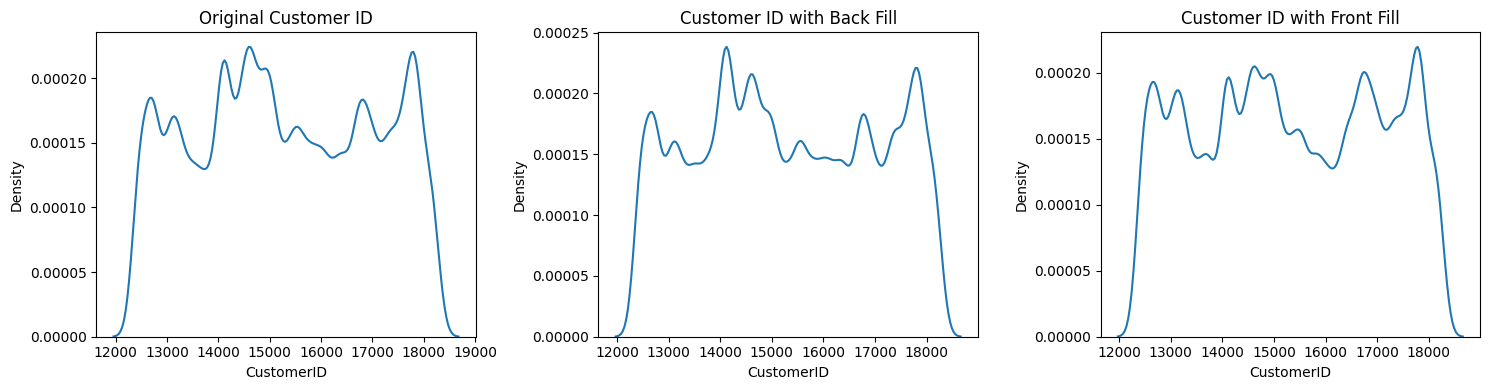

In [118]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.kdeplot(raw_df["CustomerID"])
plt.title("Original Customer ID")

plt.subplot(1,3,2)
sns.kdeplot(raw_df["CustomerID"].fillna(method = "bfill"))
plt.title("Customer ID with Back Fill")

plt.subplot(1,3,3)
sns.kdeplot(raw_df["CustomerID"].fillna(method = "ffill"))
plt.title("Customer ID with Front Fill")
plt.tight_layout()

In [119]:
UK_sales = raw_df[raw_df["Country"] == "United Kingdom"]
Rest_country_sales = raw_df[raw_df["Country"] != "United Kingdom"]

In [120]:
UK_sales['CustomerID'] = UK_sales['CustomerID'].fillna(method='ffill')
Rest_country_sales['CustomerID'] = Rest_country_sales['CustomerID'].fillna(method='ffill')

In [121]:
UK_sales.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

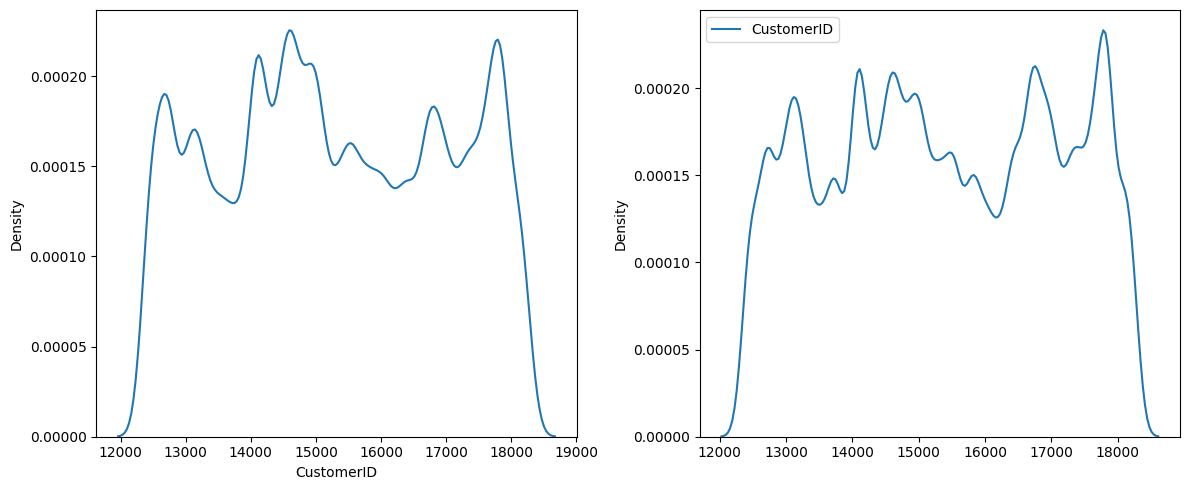

In [122]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.kdeplot(original_df["CustomerID"])

plt.subplot(1,2,2)
sns.kdeplot(pd.concat([UK_sales["CustomerID"], Rest_country_sales["CustomerID"]], axis=1))

plt.tight_layout()

plt.show()

In [123]:
UK_sales.nunique()

InvoiceNo      17901
StockCode       3906
Description     3998
Quantity         368
InvoiceDate    16695
UnitPrice        498
CustomerID      3916
Country            1
dtype: int64

In [124]:
UK_sales.describe()

Quantity      UnitPrice     CustomerID
count  478826.000000  478826.000000  478826.000000
mean        9.688421       3.301748   15559.536803
std       162.912221       4.445448    1613.197914
min         1.000000       0.001000   12346.000000
25%         1.000000       1.250000   14159.000000
50%         3.000000       2.100000   15539.000000
75%        10.000000       4.130000   16954.000000
max     80995.000000     649.500000   18287.000000

In [125]:
def calculate_iqr(series):
    # Calculate Q1 and Q3
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Calculate upper and lower fences
    upper_fence = Q3 + 1.5 * IQR
    lower_fence = Q1 - 1.5 * IQR

    # Print the fences
    return lower_fence , upper_fence

In [126]:
print(f'IQR Unit Price column: {calculate_iqr(UK_sales["UnitPrice"])}')
print(f'IQR Quantity column: {calculate_iqr(UK_sales["Quantity"])}')

IQR Unit Price column: (-3.0700000000000003, 8.45)
IQR Quantity column: (-12.5, 23.5)


In [127]:
print(f'skewness Unit Price is {UK_sales["UnitPrice"].skew()}')
print(f'skewness Quantity is {UK_sales["Quantity"].skew()}')

skewness Unit Price is 26.417414111955587
skewness Quantity is 454.3459350864091


In [128]:
from sklearn.preprocessing import FunctionTransformer
ft = FunctionTransformer(np.log1p)
UK_sales["UnitPrice_log"] = ft.fit_transform(UK_sales["UnitPrice"])
UK_sales["Quantity_log"] = ft.fit_transform(UK_sales["Quantity"])

In [129]:
# the skewness of the log columns are less than the original columns
print(f'skewness UnitPrice_log is {UK_sales["UnitPrice_log"].skew()}')
print(f'skewness Quantity_log is {UK_sales["Quantity_log"].skew()}')

skewness UnitPrice_log is 0.6939329299921252
skewness Quantity_log is 1.0829452101580714


In [130]:
print(f'The IQR for the Unit Price log column: {calculate_iqr(UK_sales["UnitPrice_log"])}')
print(f'The IQR for the Quantity log column: {calculate_iqr(UK_sales["Quantity_log"])}')

The IQR for the Unit Price log column: (-0.42533294823319556, 2.871368823632203)
The IQR for the Quantity log column: (-1.8639749577976925, 4.955017411156009)


In [131]:
UK_sales.sample()

InvoiceNo StockCode                      Description  Quantity  \
506042    579133     23029  DRAWER KNOB CRACKLE GLAZE GREEN         4   

             InvoiceDate  UnitPrice  CustomerID         Country  \
506042  28-11-2011 12:36       1.65     17852.0  United Kingdom   

        UnitPrice_log  Quantity_log  
506042        0.97456      1.609438

In [132]:
quantity_outliers = UK_sales[UK_sales["Quantity_log"]>= 4.955]
unit_price_outliers = UK_sales[UK_sales["UnitPrice_log"]>= 2.871]

In [133]:
UK_sales = UK_sales[UK_sales["UnitPrice_log"]<=2.871]
UK_sales = UK_sales[UK_sales["Quantity_log"]<=4.9550]

In [134]:
# number of rows removed from the outliers
quantity_outliers.shape[0] + unit_price_outliers.shape[0]

7100

In [135]:
f"The amount of the data lost in removing the outlier is: {(7100)*100 / 478826}"

'The amount of the data lost in removing the outlier is: 1.4827933320245767'

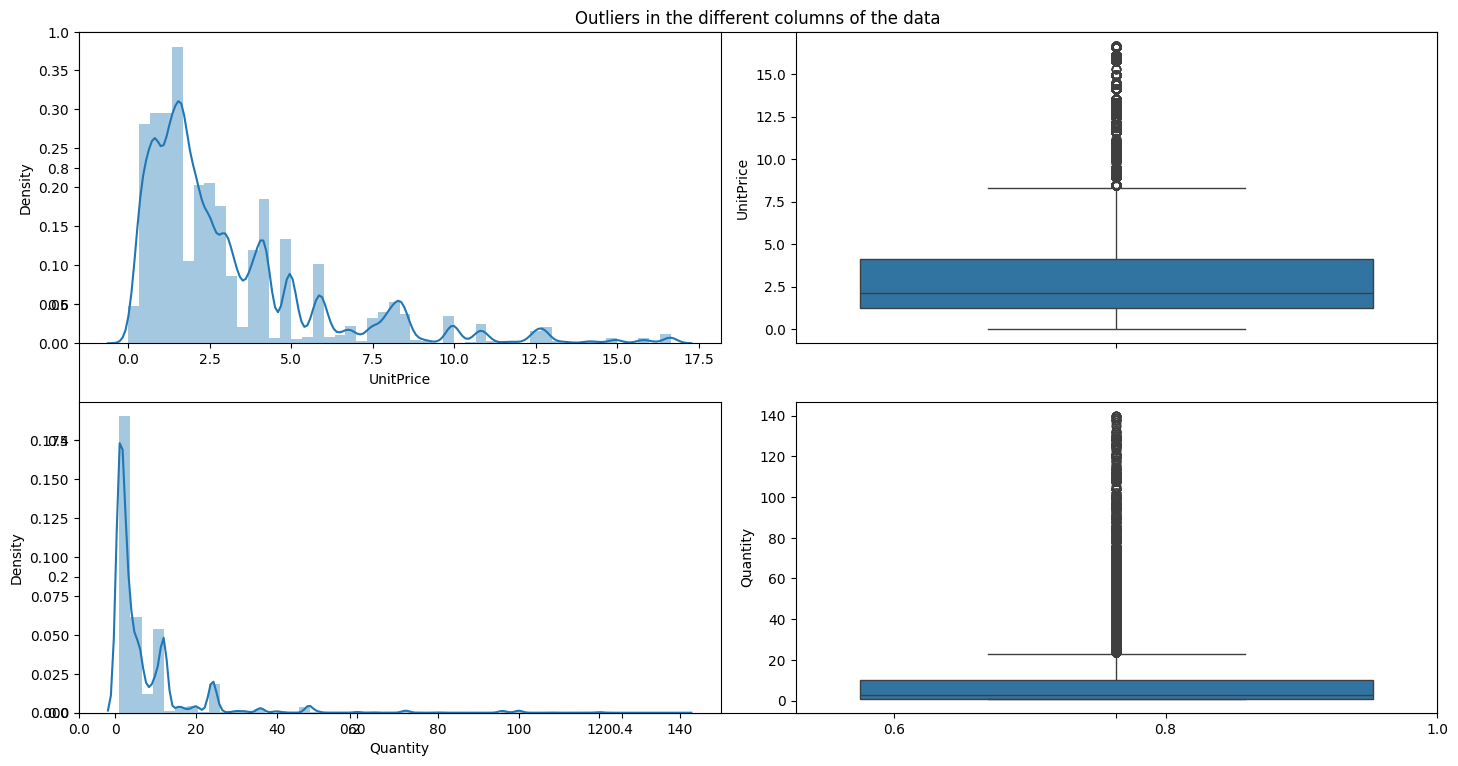

In [136]:
plt.figure(figsize=(15,8))
plt.title("Outliers in the different columns of the data")
plt.subplot(2,2,1)
sns.distplot(UK_sales["UnitPrice"])
plt.subplot(2,2,2)
sns.boxplot(UK_sales["UnitPrice"])
plt.subplot(2,2,3)
sns.distplot(UK_sales["Quantity"])
plt.subplot(2,2,4)
sns.boxplot(UK_sales["Quantity"])
plt.tight_layout()
plt.show()

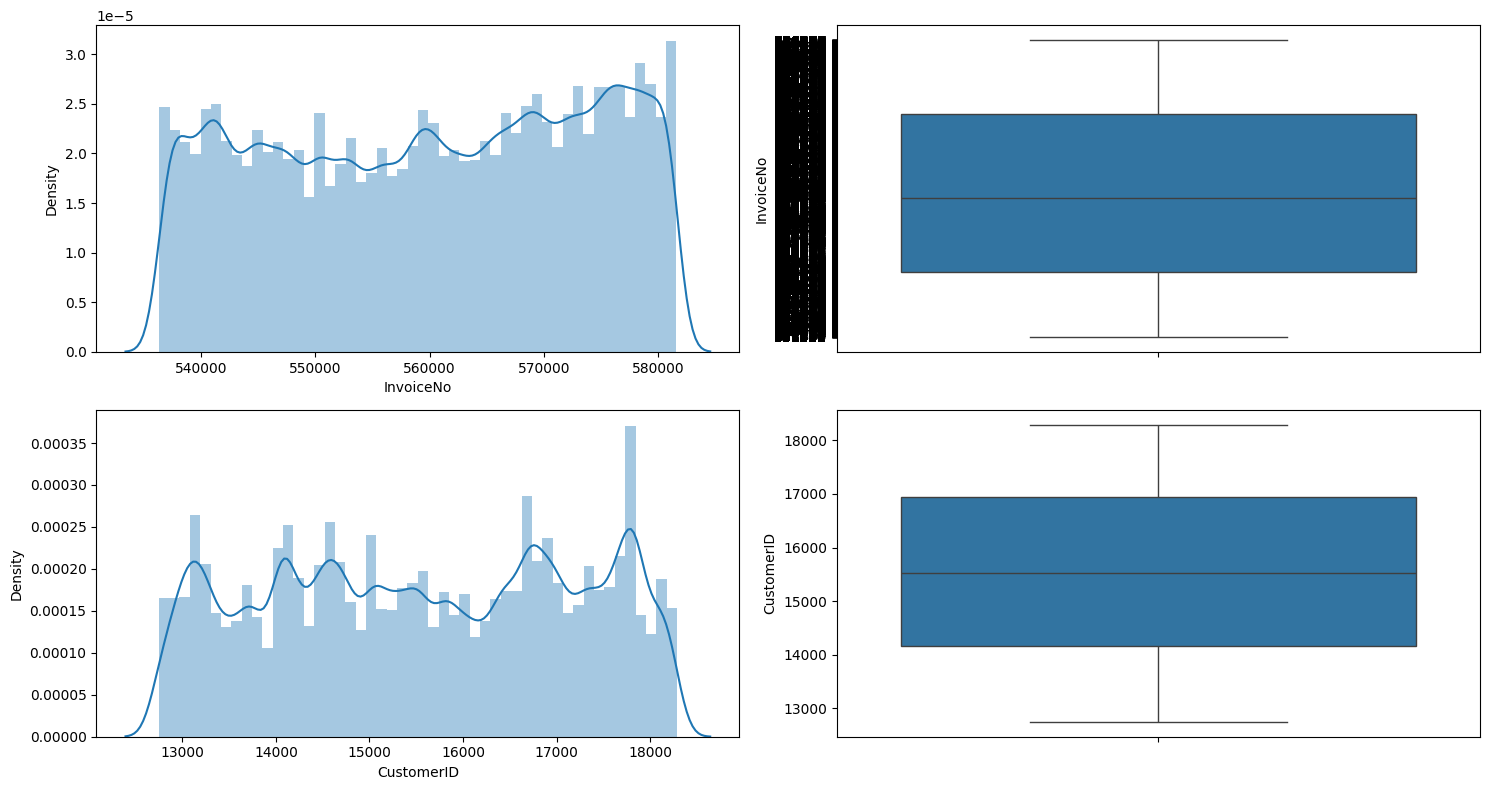

In [137]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
sns.distplot(UK_sales["InvoiceNo"])
plt.subplot(2,2,2)
sns.boxplot(UK_sales["InvoiceNo"])
plt.subplot(2,2,3)
sns.distplot(UK_sales["CustomerID"])
plt.subplot(2,2,4)
sns.boxplot(UK_sales["CustomerID"])
plt.tight_layout()
plt.show()

In [138]:
# Calculate 'Revenue' by multiplying 'Quantity' and 'UnitPrice'
UK_sales["Revenue"] = UK_sales["Quantity"] * UK_sales["UnitPrice"]

# Convert 'Revenue' to an integer type to save memory
UK_sales["Revenue"] = UK_sales["Revenue"].astype("int32")

In [139]:
# Convert 'InvoiceDate' column to datetime format, specifying the date format and using dayfirst=True
UK_sales["InvoiceDate"] = pd.to_datetime(UK_sales["InvoiceDate"], format='%d-%m-%Y %H:%M', dayfirst=True)

# Extract the year from 'InvoiceDate'
UK_sales['Year'] = UK_sales['InvoiceDate'].dt.year

# Extract the month from 'InvoiceDate'
UK_sales['Month'] = UK_sales['InvoiceDate'].dt.month

# Extract the day of the month from 'InvoiceDate'
UK_sales['Day'] = UK_sales['InvoiceDate'].dt.day

# Extract the day of the week (as a number) from 'InvoiceDate' (0=Monday, 6=Sunday)
UK_sales['day_of_week'] = UK_sales['InvoiceDate'].dt.day_of_week

# Get the name of the day of the week from 'InvoiceDate' (e.g., 'Monday', 'Tuesday')
UK_sales['day_name'] = UK_sales['InvoiceDate'].dt.day_name()

# Extract the quarter of the year from 'InvoiceDate' (1-4)
UK_sales['quarter'] = UK_sales['InvoiceDate'].dt.quarter


In [140]:
UK_sales.shape

(471726, 17)

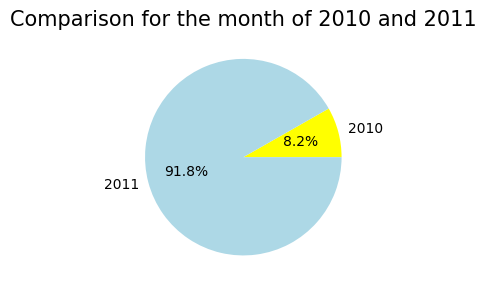

In [141]:
plt.figure(figsize=(10,3))
plt.pie(UK_sales.groupby("Year")["Revenue"].sum().values, labels=UK_sales.groupby("Year")["Revenue"].sum().index, autopct='%1.1f%%', colors=["yellow","lightblue"]);
plt.title("Comparison for the month of 2010 and 2011", fontsize = 15)
plt.tight_layout()

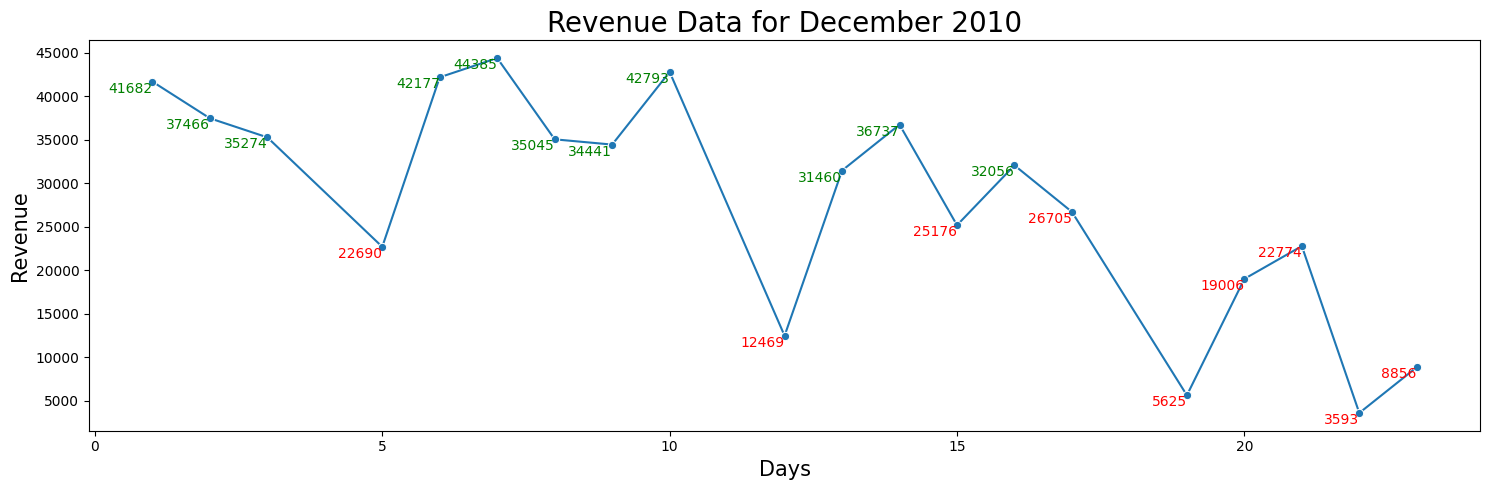

In [142]:
# Filter and group data
data_dec2010 = UK_sales[(UK_sales["Year"] == 2010) & (UK_sales["Month"] == 12)].groupby("Day")["Revenue"].sum()

avg_price_dec2010 = data_dec2010.mean()
# Create the line plot
plt.figure(figsize=(15, 5))
ax = sns.lineplot(
    x=data_dec2010.index,
    y=data_dec2010.values,
    marker="o"
)

# Set labels and title
plt.ylabel("Revenue", fontsize=15)
plt.xlabel("Days", fontsize=15)
plt.title("Revenue Data for December 2010", fontsize=20)

# Annotate points
for x, y in zip(data_dec2010.index, data_dec2010.values):
    color = "green" if y > avg_price_dec2010 else "red"
    plt.text(x, y, f'{y}', ha="right", va='top', color=color)

plt.tight_layout()
plt.show()

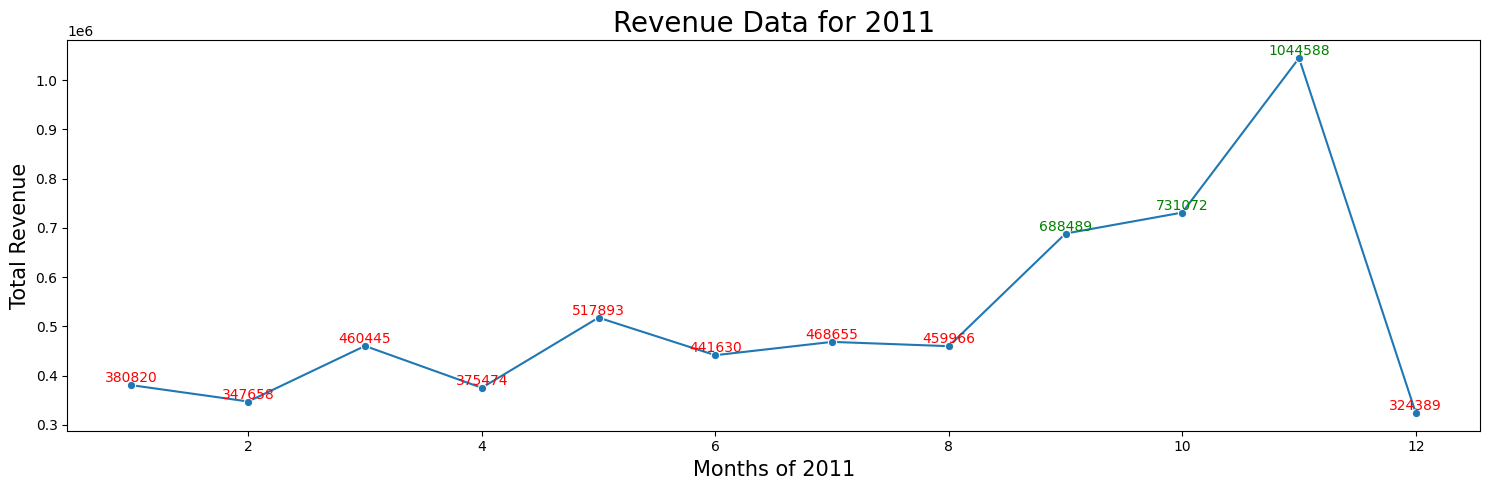

In [143]:
# Filter and group data for the year 2011
data_2011 = UK_sales[UK_sales["Year"] == 2011].groupby("Month")["Revenue"].sum()

# Calculate the mean revenue for 2011
mean_2011 = data_2011.mean()

# Create the line plot
plt.figure(figsize=(15, 5))
sns.lineplot(
    x=data_2011.index,
    y=data_2011.values,
    marker="o"
)
plt.ylabel("Total Revenue", fontsize=15)
plt.xlabel("Months of 2011", fontsize=15)
plt.title("Revenue Data for 2011", fontsize=20)

# Annotate points
for x, y in zip(data_2011.index, data_2011.values):
    color = "green" if y > mean_2011 else "red"
    plt.text(x, y, f'{y}', ha="center", va="bottom", color=color)

plt.tight_layout()
plt.show()

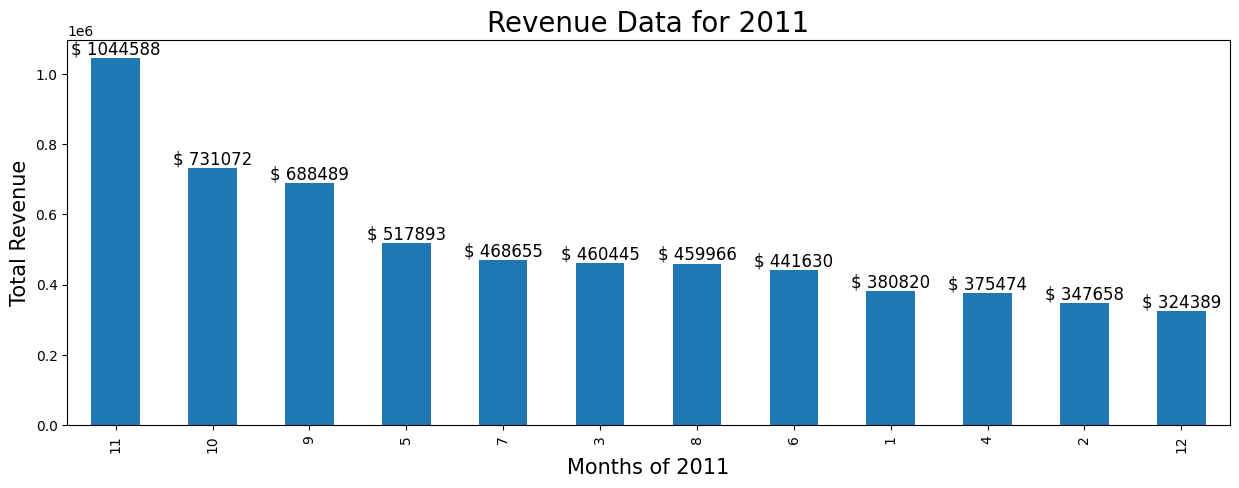

In [144]:
plt.figure(figsize=(15, 5))
ax = data_2011.sort_values(ascending=False).plot(kind="bar")
plt.xlabel("Months of 2011", fontsize=15)
plt.ylabel("Total Revenue", fontsize=15)
plt.title("Revenue Data for 2011", fontsize=20)

for container in ax.containers:
    ax.bar_label(container, fmt='$ %.0f', fontsize=12)
plt.show()

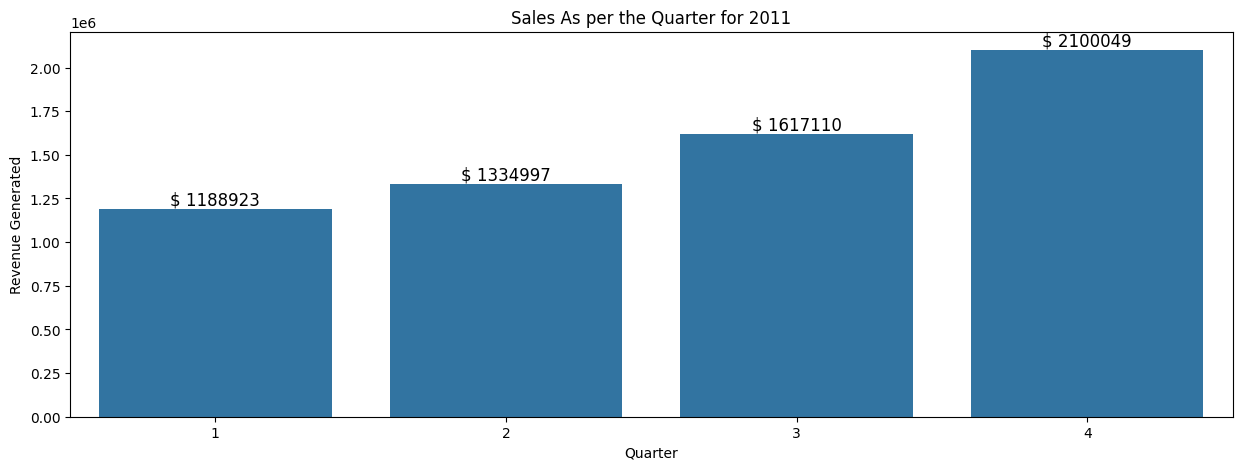

In [145]:
#quarterly sales report
plt.figure(figsize=(15, 5))
ax = sns.barplot(
    x = UK_sales[UK_sales["Year"] == 2011].groupby("quarter")["Revenue"].sum().index,
    y = UK_sales[UK_sales["Year"] == 2011].groupby("quarter")["Revenue"].sum().values)
plt.title("Sales As per the Quarter for 2011")
plt.xlabel("Quarter")
plt.ylabel("Revenue Generated")
for container in ax.containers:
    ax.bar_label(container, fmt='$ %.0f', fontsize=12)

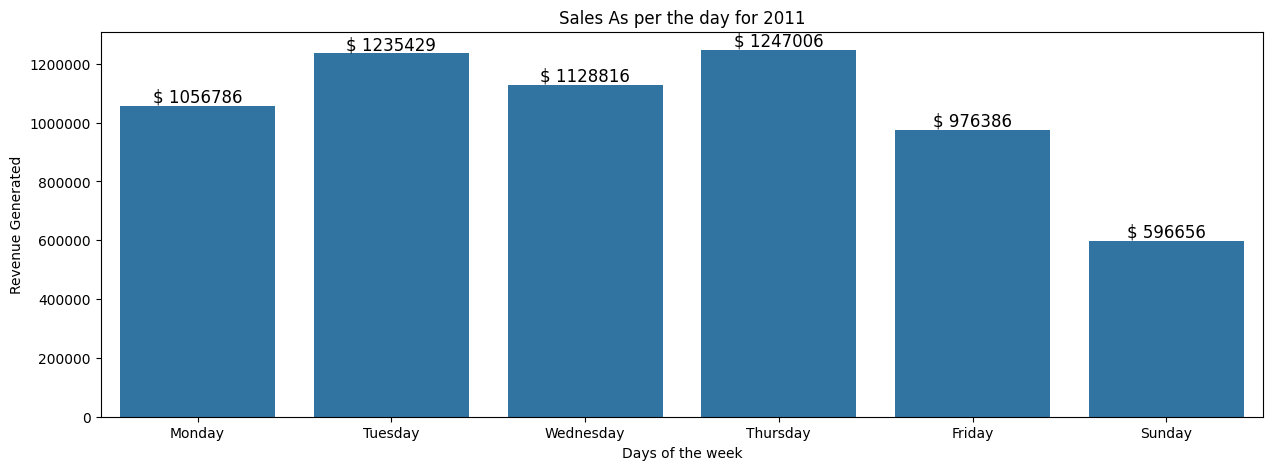

In [146]:
# sales data according to the days of the week
plt.figure(figsize=(15, 5))
ax = sns.barplot(
    x = UK_sales[UK_sales["Year"] == 2011].groupby("day_of_week")["Revenue"].sum().index,
    y = UK_sales[UK_sales["Year"] == 2011].groupby("day_of_week")["Revenue"].sum().values)
plt.title("Sales As per the day for 2011")
plt.xticks([0, 1, 2,3,4,5], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Sunday"])
plt.xlabel("Days of the week")
plt.ylabel("Revenue Generated")
plt.ticklabel_format(style='plain', axis='y')
for container in ax.containers:
    ax.bar_label(container, fmt='$ %.0f', fontsize=12)

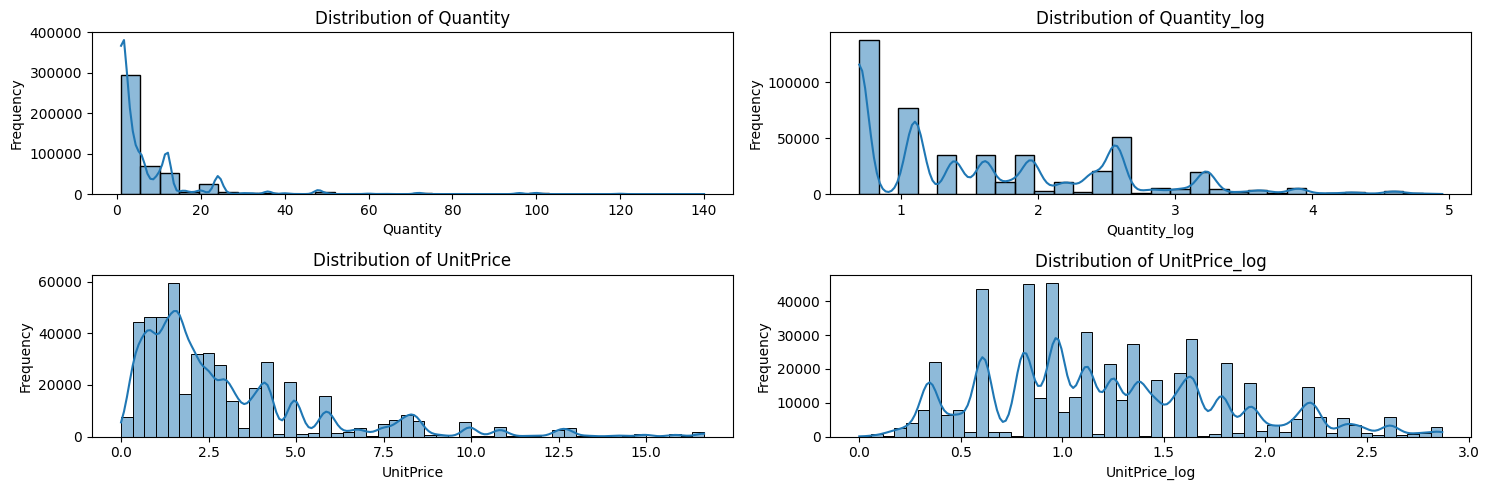

<Figure size 640x480 with 0 Axes>

In [147]:
plt.figure(figsize=(15, 5))

bins=30
plt.subplot(2,2,1)
sns.histplot(UK_sales["Quantity"], kde=True, bins=bins)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity")
plt.ylabel("Frequency")

plt.subplot(2,2,2)
sns.histplot(UK_sales["Quantity_log"], kde=True, bins=bins)
plt.title("Distribution of Quantity_log")
plt.xlabel("Quantity_log")
plt.ylabel("Frequency")

bins=50
plt.subplot(2,2,3)  # Arrange the subplots in a 2x2 grid
sns.histplot(UK_sales["UnitPrice"], kde=True, bins=bins)
plt.title("Distribution of UnitPrice")
plt.xlabel("UnitPrice")
plt.ylabel("Frequency")

plt.subplot(2,2,4)  # Arrange the subplots in a 2x2 grid
sns.histplot(UK_sales["UnitPrice_log"], kde=True, bins=bins)
plt.title("Distribution of UnitPrice_log")
plt.xlabel("UnitPrice_log")
plt.ylabel("Frequency")

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()


plt.tight_layout()
plt.show()

In [148]:
print("The Count of Unique Invoice Generated",UK_sales["InvoiceNo"].nunique())
Invoice_number = UK_sales["InvoiceNo"].unique()
print("Unique Invoice number",Invoice_number)

The Count of Unique Invoice Generated 17497
Unique Invoice number ['536365' '536366' '536367' ... '581584' '581585' '581586']


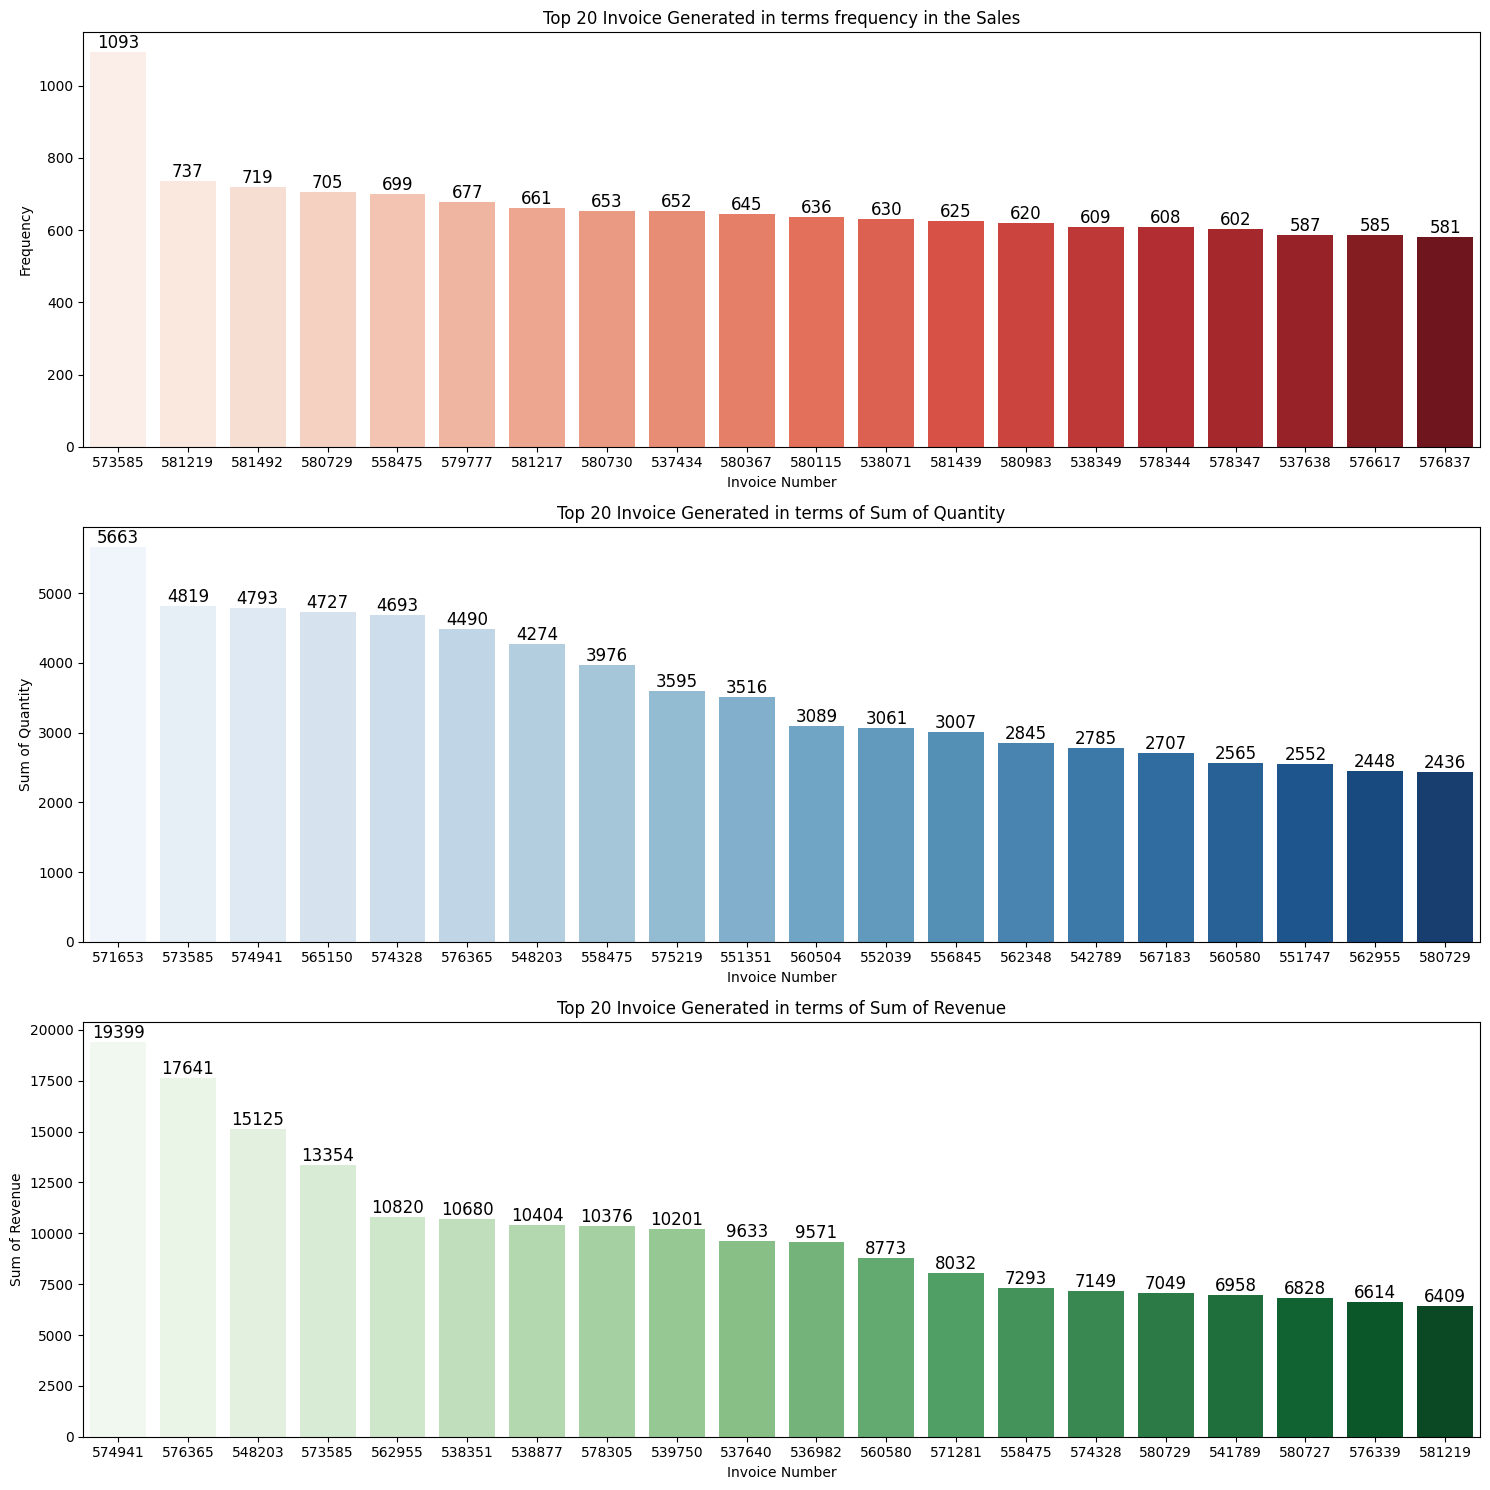

In [149]:
plt.figure(figsize=(15, 15))

plt.subplot(3,1,1)
ax = sns.barplot(UK_sales["InvoiceNo"].value_counts().head(20),palette="Reds")
plt.title("Top 20 Invoice Generated in terms frequency in the Sales")
plt.xlabel("Invoice Number")
plt.ylabel("Frequency")
for container in ax.containers:
    ax.bar_label(container, fontsize=12)

plt.subplot(3,1,2)
ax = sns.barplot(
    x = UK_sales.groupby("InvoiceNo").agg({"Quantity": "sum"}).sort_values(by="Quantity", ascending=False).head(20).index,
    y = UK_sales.groupby("InvoiceNo").agg({"Quantity": "sum"}).sort_values(by="Quantity", ascending=False).head(20)["Quantity"],palette="Blues")
plt.title("Top 20 Invoice Generated in terms of Sum of Quantity")
plt.xlabel("Invoice Number")
plt.ylabel("Sum of Quantity")
for container in ax.containers:
    ax.bar_label(container, fontsize=12)

plt.subplot(3,1,3)
ax = sns.barplot(
    x = UK_sales.groupby("InvoiceNo").agg({"Revenue": "sum"}).sort_values(by="Revenue", ascending=False).head(20).index,
    y = UK_sales.groupby("InvoiceNo").agg({"Revenue": "sum"}).sort_values(by="Revenue", ascending=False).head(20)["Revenue"],palette="Greens")
plt.title("Top 20 Invoice Generated in terms of Sum of Revenue")
plt.xlabel("Invoice Number")
plt.ylabel("Sum of Revenue")
for container in ax.containers:
    ax.bar_label(container, fontsize=12)


plt.tight_layout()
plt.show()

In [150]:
print("The Count of CustomerID in the sales",UK_sales["CustomerID"].nunique())
Customer_id = UK_sales["CustomerID"].unique()
print("Unique CustomerID",Customer_id)

The Count of CustomerID in the sales 3877
Unique CustomerID [17850. 13047. 13748. ... 15520. 13298. 14569.]


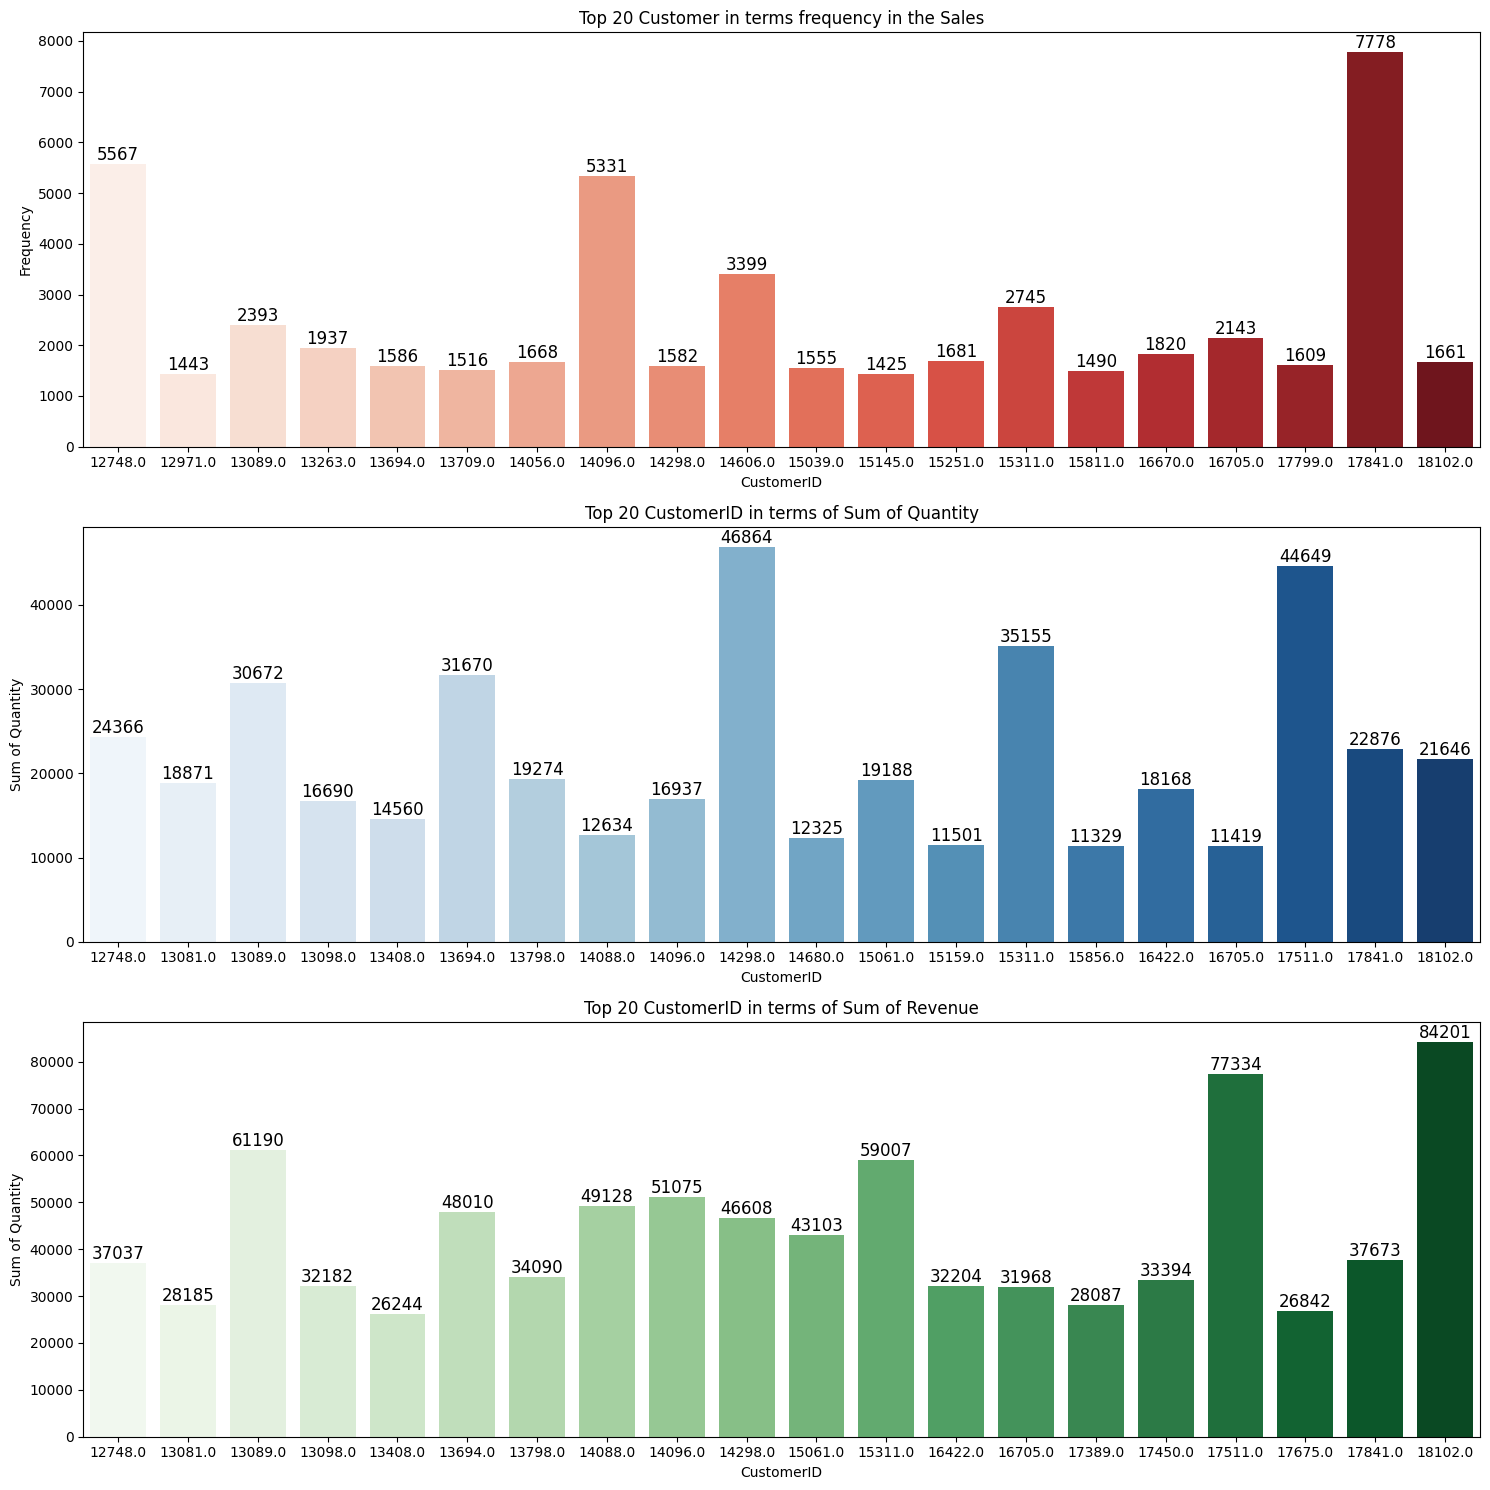

In [151]:

plt.figure(figsize=(15, 15))

plt.subplot(3,1,1)
ax = sns.barplot(UK_sales["CustomerID"].value_counts().head(20),palette="Reds")
plt.title("Top 20 Customer in terms frequency in the Sales")
plt.xlabel("CustomerID")
plt.ylabel("Frequency")
for container in ax.containers:
    ax.bar_label(container, fontsize=12)

plt.subplot(3,1,2)
ax = sns.barplot(
    x = UK_sales.groupby("CustomerID").agg({"Quantity": "sum"}).sort_values(by="Quantity", ascending=False).head(20).index,
    y = UK_sales.groupby("CustomerID").agg({"Quantity": "sum"}).sort_values(by="Quantity", ascending=False).head(20)["Quantity"],palette="Blues")
plt.title("Top 20 CustomerID in terms of Sum of Quantity")
plt.xlabel("CustomerID")
plt.ylabel("Sum of Quantity")
for container in ax.containers:
    ax.bar_label(container, fontsize=12)

plt.subplot(3,1,3)
ax = sns.barplot(
    x = UK_sales.groupby("CustomerID").agg({"Revenue": "sum"}).sort_values(by="Revenue", ascending=False).head(20).index,
    y = UK_sales.groupby("CustomerID").agg({"Revenue": "sum"}).sort_values(by="Revenue", ascending=False).head(20)["Revenue"],palette="Greens")
plt.title("Top 20 CustomerID in terms of Sum of Revenue")
plt.xlabel("CustomerID")
plt.ylabel("Sum of Quantity")
for container in ax.containers:
    ax.bar_label(container, fontsize=12)

plt.tight_layout()
plt.show()

In [152]:
print("The Count of Unique Stock Codes",UK_sales["StockCode"].nunique())
print("Unique Stock Codes",UK_sales["StockCode"].unique())

The Count of Unique Stock Codes 3864
Unique Stock Codes ['85123A' '71053' '84406B' ... '84679' '47591b' '72783']


In [153]:
least_selling_stock_codes=[]
stockcode = UK_sales["StockCode"].value_counts()

# Loop through each unique StockCode
for stock_code in stockcode.index:
    # Check if the count for the current stock code is between 0 and 5
    if stockcode[stock_code] <= 5:
        least_selling_stock_codes.append(stock_code)


In [154]:
least_selling_items = UK_sales[UK_sales["StockCode"].isin(least_selling_stock_codes)]

In [155]:
print(f'Revenue generated from the least selling item in the data: ${UK_sales[UK_sales["StockCode"].isin(least_selling_stock_codes)]["Revenue"].sum()}')

Revenue generated from the least selling item in the data: $13820


Text(0.5, 1.0, 'Highest 10 selling products in the month of the year 2011 in the terms of revenue and consistency')

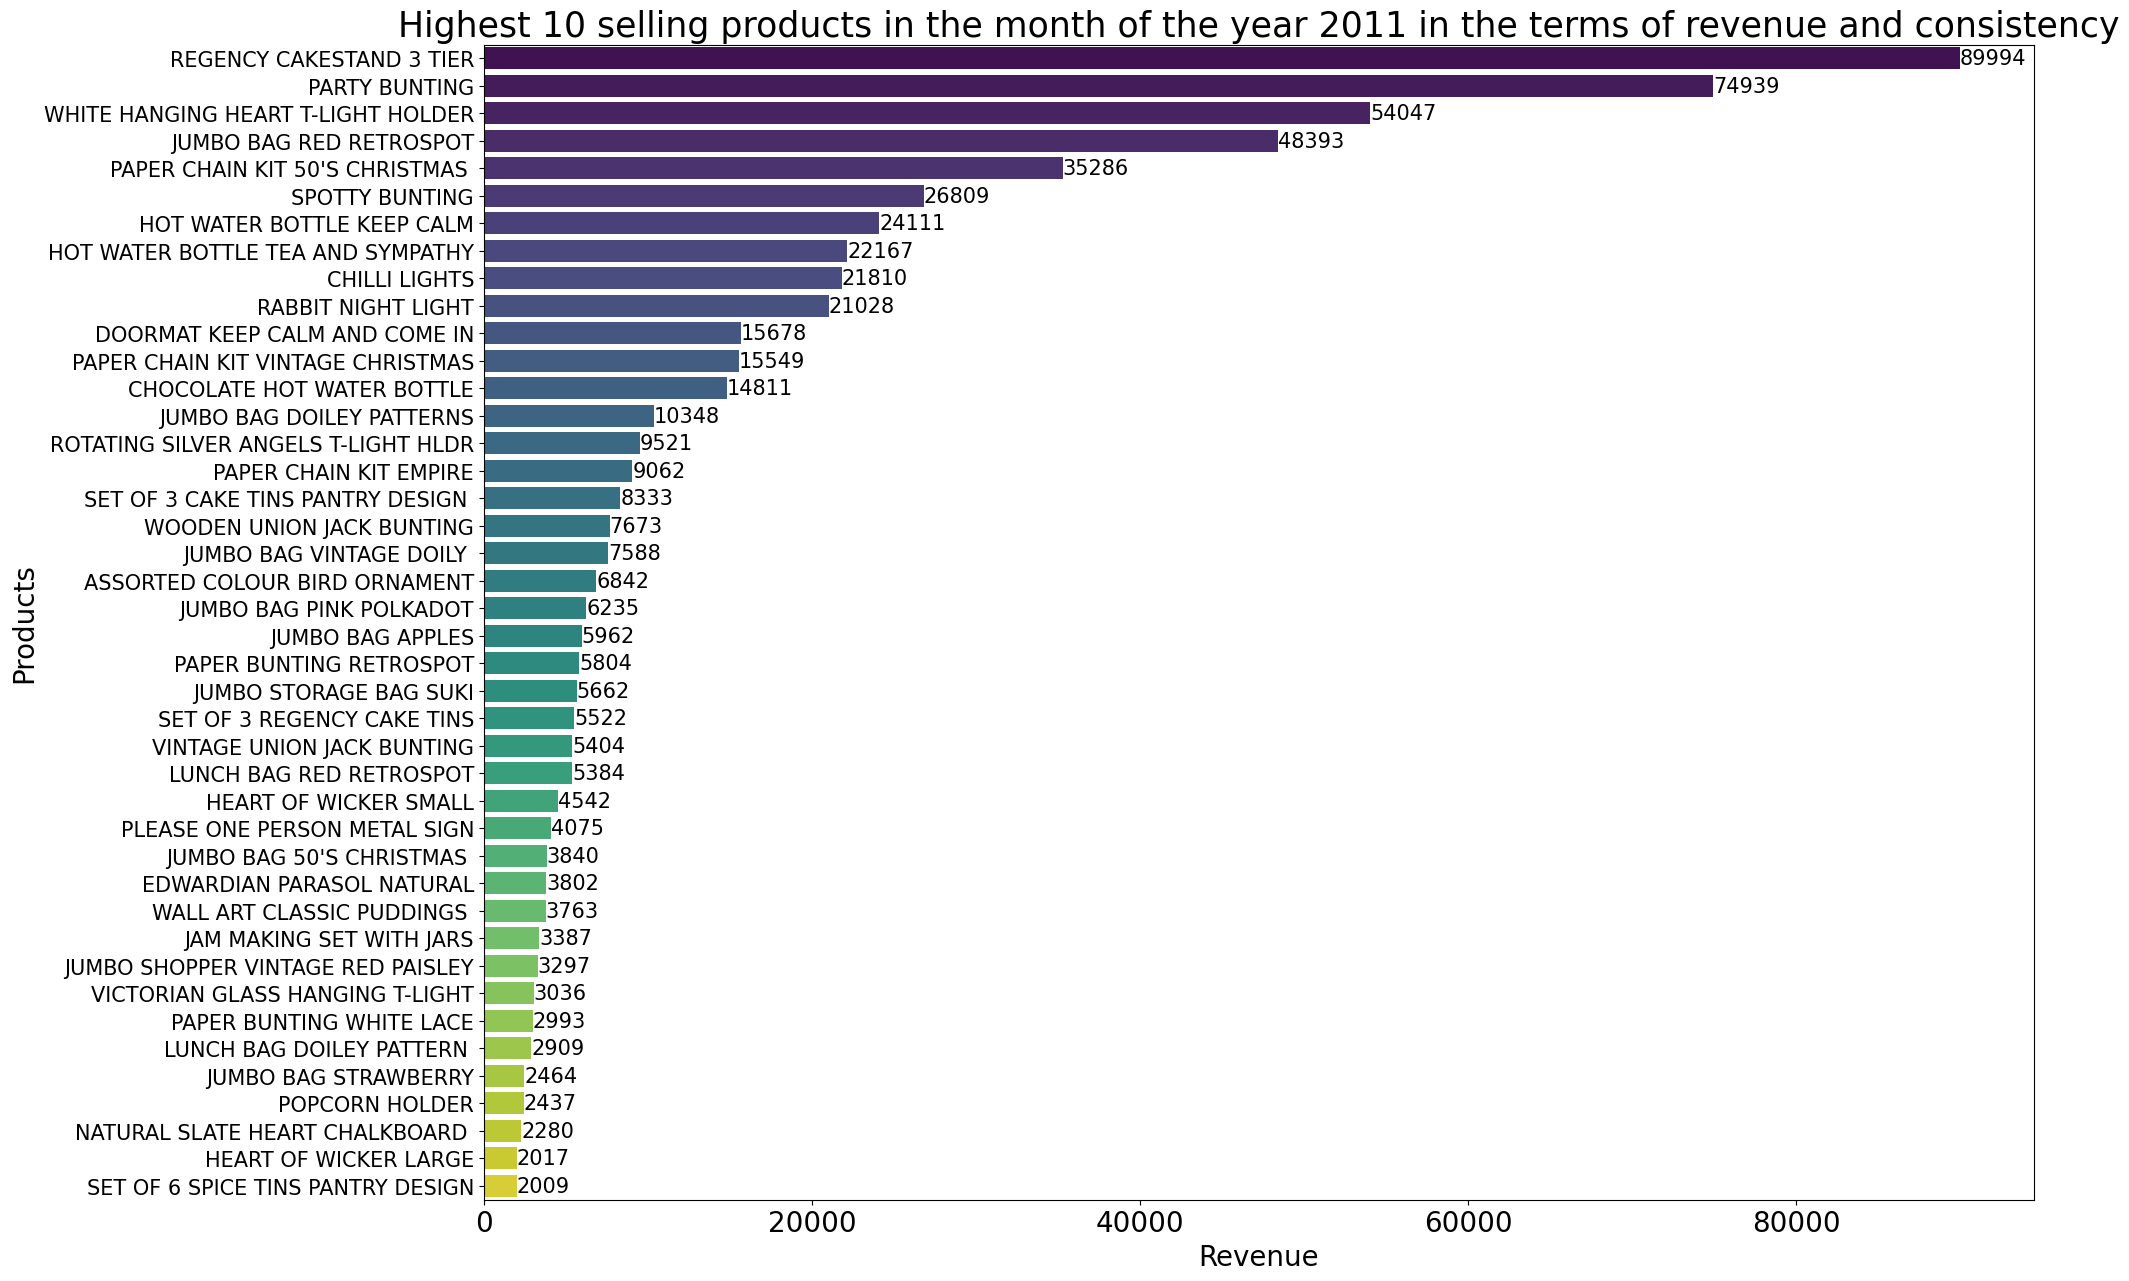

In [156]:
top_10_by_month = {}
for i in UK_sales[UK_sales["Year"] == 2011]["Month"].unique():
     top_10_by_month[i] = (
        UK_sales[(UK_sales["Year"] == 2011) & (UK_sales["Month"] == i)]
        .groupby("Description")["Revenue"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
        .rename_axis(None)
    )

top_10_by_2011_month = pd.DataFrame(top_10_by_month)

plt.figure(figsize=(20, 15))
ax = sns.barplot(
    y = top_10_by_2011_month.sum(axis=1).sort_values(ascending=False).index,
    x = top_10_by_2011_month.sum(axis=1).sort_values(ascending=False).values,
    palette='viridis' )
plt.yticks(fontsize=15)
plt.xticks(fontsize=20)
for container in ax.containers:
    ax.bar_label(container, fontsize=15)
plt.xlabel("Revenue",fontsize = 20)
plt.ylabel("Products",fontsize = 20)
plt.title("Highest 10 selling products in the month of the year 2011 in the terms of revenue and consistency", fontsize = 25)



In [157]:
top_10_by_2011_month_map = top_10_by_2011_month.applymap(lambda x: 0 if pd.isna(x) else 1)
top_10_by_2011_month_map["Sum"] = top_10_by_2011_month_map.sum(axis=1)

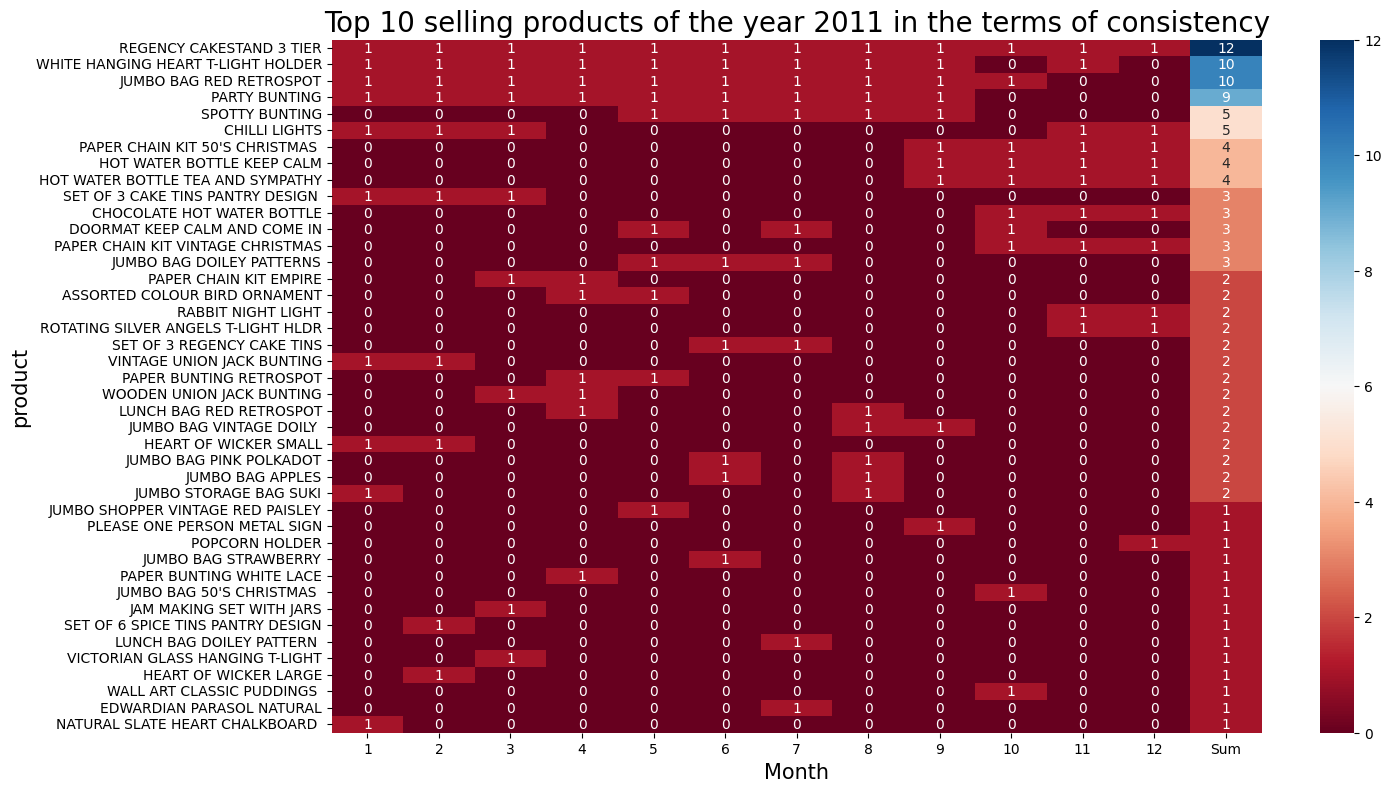

In [158]:
plt.figure(figsize=(15,9))
sns.heatmap(top_10_by_2011_month_map.sort_values(by = "Sum", ascending=False),
            cmap="RdBu",  # Choose a color map
            annot=True,    # Annotate the cells with the values (0 or 1)
            cbar=True)    # Disable the color bar
plt.xlabel("Month",fontsize = 15)
plt.ylabel("product",fontsize = 15)
plt.title("Top 10 selling products of the year 2011 in the terms of consistency", fontsize = 20);


Text(0.5, 1.0, 'Top 20 selling products in the month of the year 2011 in terms of revenue')

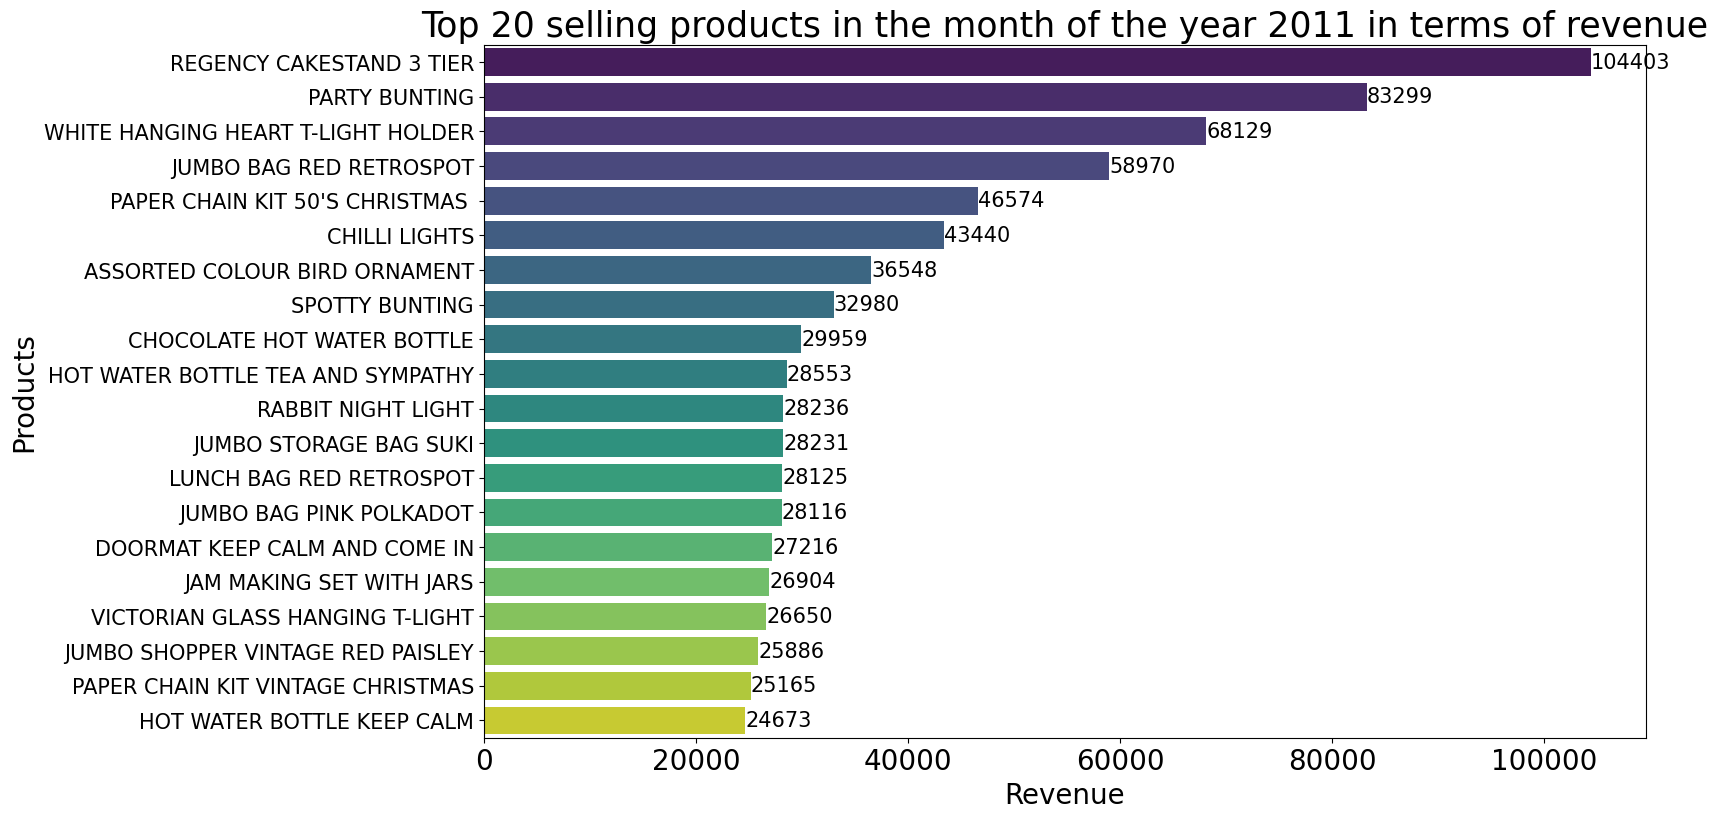

In [159]:
plt.figure(figsize=(15,9))
ax = sns.barplot(
    x = UK_sales.groupby("Description")["Revenue"].sum().sort_values(ascending=False).head(20).values,
    y = UK_sales.groupby("Description")["Revenue"].sum().sort_values(ascending=False).head(20).index,palette='viridis' )

plt.yticks(fontsize=15)
plt.xticks(fontsize=20)

for container in ax.containers:
    ax.bar_label(container, fontsize=15)
plt.xlabel("Revenue",fontsize = 20)
plt.ylabel("Products",fontsize = 20)
plt.title("Top 20 selling products in the month of the year 2011 in terms of revenue", fontsize = 25)


# Bivariate

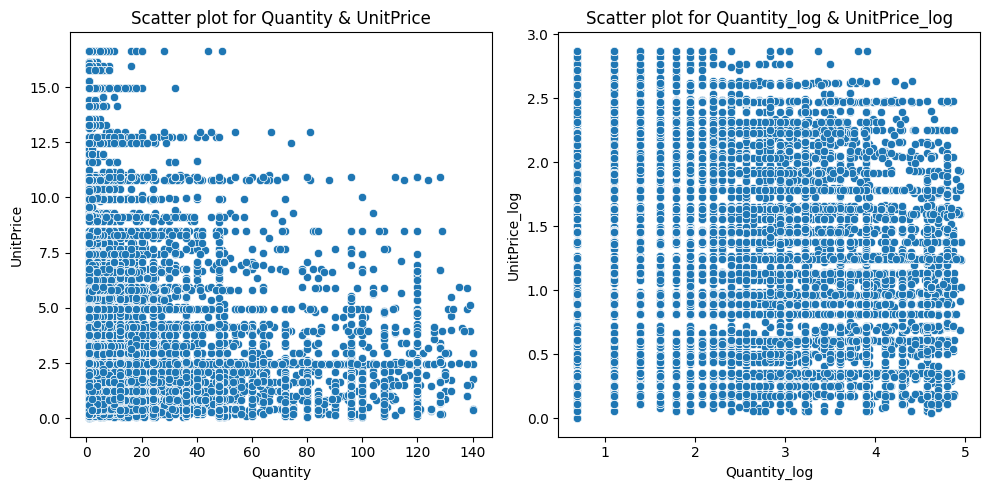

In [160]:

plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)  # Arrange the subplots in a 2x2 grid
sns.scatterplot(data = UK_sales, x="Quantity", y="UnitPrice")
plt.title("Scatter plot for Quantity & UnitPrice")
plt.xlabel("Quantity")
plt.ylabel("UnitPrice")

plt.subplot(1,2,2)  # Arrange the subplots in a 2x2 grid
sns.scatterplot(data = UK_sales, x="Quantity_log", y="UnitPrice_log")
plt.title("Scatter plot for Quantity_log & UnitPrice_log")
plt.xlabel("Quantity_log")
plt.ylabel("UnitPrice_log")

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

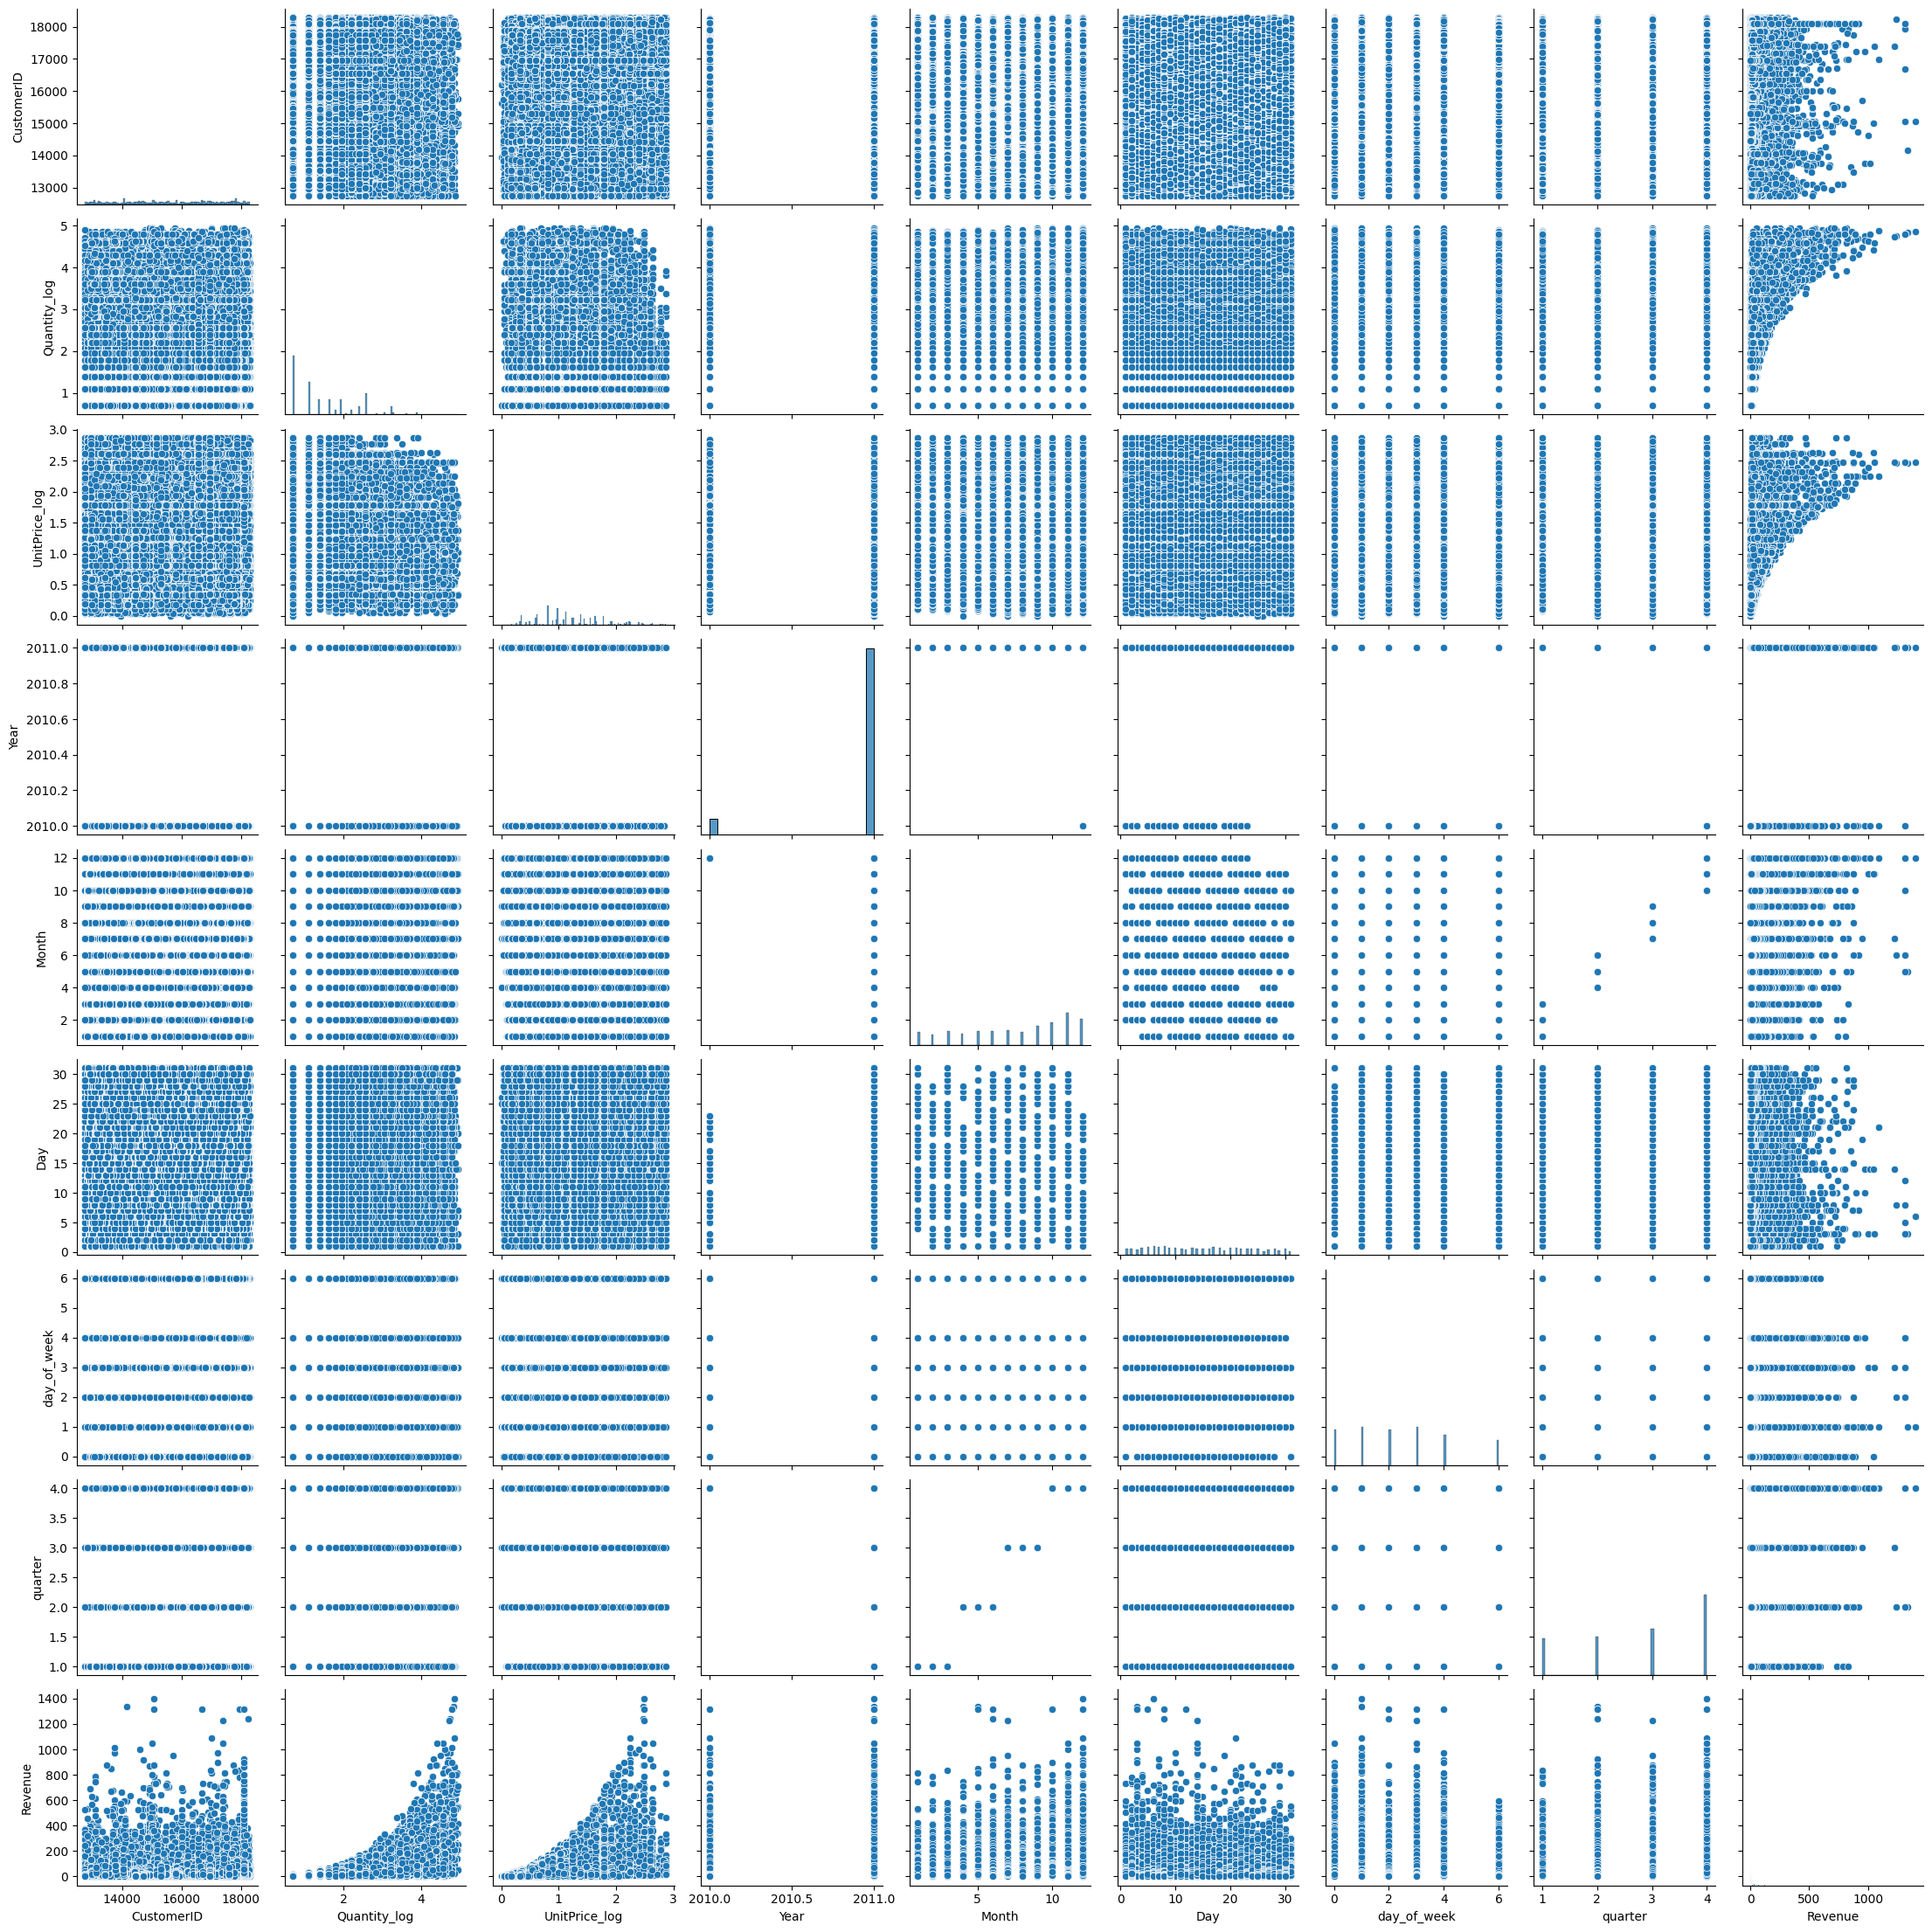

In [161]:
# Pair plot for selected numerical variables
sns.pairplot(UK_sales[['InvoiceNo', 'CustomerID','Quantity_log', 'UnitPrice_log', 'Year', 'Month', 'Day', 'day_of_week','quarter','Revenue']])
plt.show()

In [162]:
UK_sales.sample()

InvoiceNo StockCode                      Description  Quantity  \
107538    545461     22951  60 CAKE CASES DOLLY GIRL DESIGN        24   

               InvoiceDate  UnitPrice  CustomerID         Country  \
107538 2011-03-03 08:24:00       0.55     14388.0  United Kingdom   

        UnitPrice_log  Quantity_log  Revenue  Year  Month  Day  day_of_week  \
107538       0.438255      3.218876       13  2011      3    3            3   

        day_name  quarter  
107538  Thursday        1

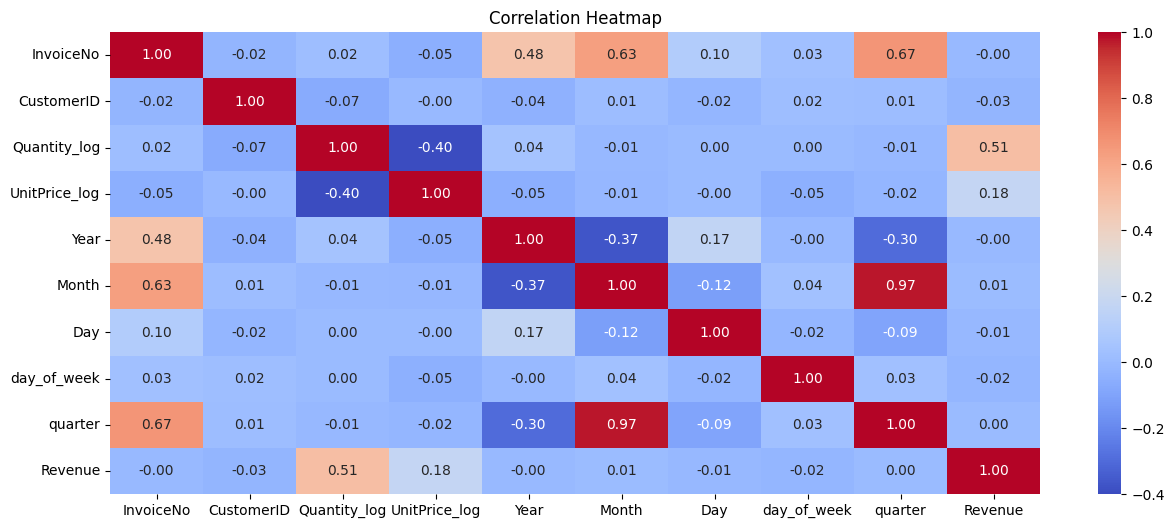

In [163]:
numerical_cols = ['InvoiceNo', 'CustomerID','Quantity_log', 'UnitPrice_log', 'Year', 'Month', 'Day', 'day_of_week','quarter','Revenue']
# Correlation heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(UK_sales[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [164]:
# Here the Quantity Log and the Unit Price Log columns are showing correlation of -0.40
# The year and the Month column are showing correlation of -0.37
# Month and quarter 0.97
# year and quarter are showing correlation of -0.30
# dropping the year column

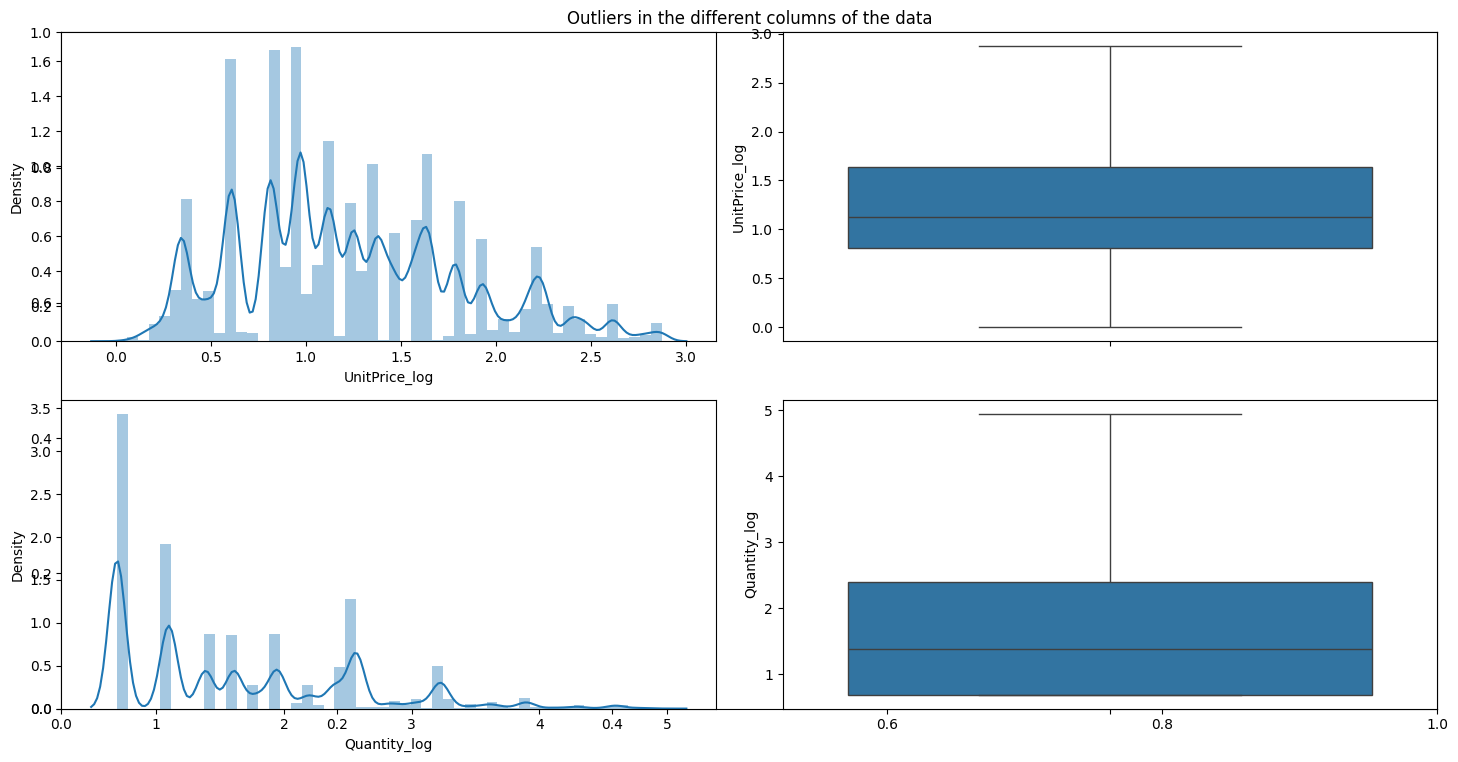

In [165]:
plt.figure(figsize=(15,8))
plt.title("Outliers in the different columns of the data")
plt.subplot(2,2,1)
sns.distplot(UK_sales["UnitPrice_log"])
plt.subplot(2,2,2)
sns.boxplot(UK_sales["UnitPrice_log"])
plt.subplot(2,2,3)
sns.distplot(UK_sales["Quantity_log"])
plt.subplot(2,2,4)
sns.boxplot(UK_sales["Quantity_log"])
plt.tight_layout()

In [167]:
UK_sales.to_csv("UK_sales_for_ML.csv",index=False)